**COMP0120 Project Code - Support Vector Machines (SVMs)**

**John Duffy, Student Number: 19154676**

# Global Imports

In [1]:
# Global imports.

import matplotlib.pyplot as plt
import numpy as np


# Dataset

For this project I have decided to use the Iris dataset included with Scikit-Learn. This is a well studied dataset in the literature, so may appear a *boring* choice. However, it provides clean and multi-class data which can be used to validate my code against other well established code, such as Scikit-Learn.

In [2]:
# Import and load Iris dataset.

from sklearn import datasets

iris = datasets.load_iris()

X = iris["data"]
y = iris["target"]
y_names = iris["target_names"]


# Introduction

## An Aside about Python and *lambda* expressions

In Python functions are first class citizens, which means just they can be passed to and returned from functions in the same manner as variables. This is simialr to MatLab function handles. And it is sometimes convenient, and clearer, to write a short function as a *lambda*, or an anonymous function, rather that a write a full function declaration. A *lambda* can be assigned to a variable, but it doesn't have to be.

For example:
```
def kernel_linear(xi, xj):
    return np.dot(xi, xj)
```
is the same as the following:
```
kernel_linear = lambda xi, xj: np.dot(xi, xj)
```
An example of using a *lambda* anonymously is as follows, which passes a kernel function as a parameter but without first assiging it to a variable:
```
classifier.train(X, y, lambda xi, xj: np.dot(xi, xj))
```
I have used this functionality throughout my code for clarity and brevity.

## Linear Binary Classification

Generate some images for my report.

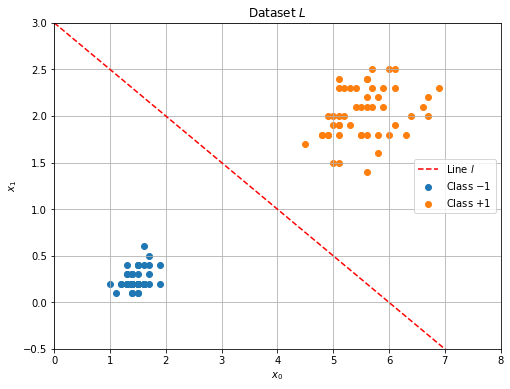

In [3]:
# intro_0.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.0
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_0.pdf")
plt.show()


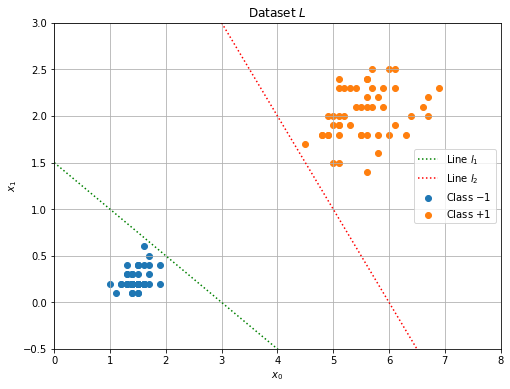

In [4]:
# intro_02.pdf

labels = ["Class $-1$", "Class $+1$"]
plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)
for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.5
x1 = m * x0 + c
plt.plot(x0, x1, ":g", label="Line $l_1$")
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -1
c = 6
x1 = m * x0 + c
plt.plot(x0, x1, ":r", label="Line $l_2$")
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_1.pdf")
plt.show()


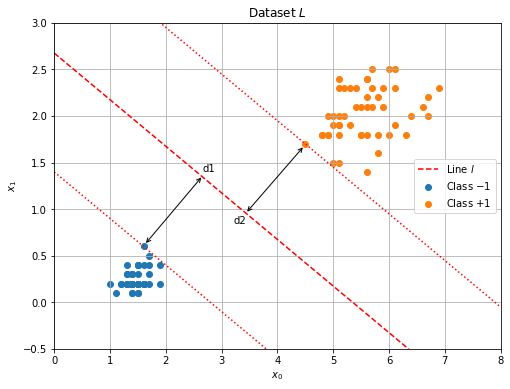

In [5]:
# intro_03.pdf

labels = ["Class $-1$", "Class $+1$"]

plt.figure(figsize=(8, 6))
plt.xlim(0, 8)
plt.ylim(-0.5, 3)

for i, value in enumerate([0, 2]):
    plt.scatter(X[y == value, 2], X[y == value, 3], label=labels[i])

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 1.4
x1 = m * x0 + c
plt.plot(x0, x1, ":r")

x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 3.95
x1 = m * x0 + c
plt.plot(x0, x1, ":r")
x0 = np.arange(plt.xlim()[0], plt.xlim()[1], 0.01)
m = -0.5
c = 2.675
x1 = m * x0 + c
plt.plot(x0, x1, "--r", label="Line $l$")
plt.annotate("d1", xy=(1.62, 0.62), xytext=(2.65, 1.4), arrowprops=dict(arrowstyle="<->"))
plt.annotate("d2", xy=(4.48, 1.68), xytext=(3.21, 0.85), arrowprops=dict(arrowstyle="<->"))
plt.title("Dataset $L$")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(loc="center right")
plt.grid()
plt.savefig("intro_2.pdf")
plt.show()


# Mathematical Setting

## Linear Binary Classification

### Backtracking and Steepest Descent

In [6]:
# Steepest_descent and backtracking.

def backtracking(f, df, x, p, alpha0=1.0, rho=0.1, c1=1e-4):
    '''
    This function implements the backtracking algorithm. Note the use of
    lambda expressions to pass the f and df parameters. This function
    returns a Numpy array of the alpha iterations.
    '''
    alpha = alpha0
    alphas = [alpha]
    while f(x + alpha * p) > f(x) + c1 * alpha * np.dot(df(x), p):
        alpha = rho * alpha
        alphas.append(alpha)
    return np.array(alphas)


def steepest_descent(f, df, d2f, x0, tol=1e-6):  # d2f Ignored!
    '''
    This function implements the steepest descent algorithm. Note the use of
    lambda expressions to pass the f and df parameters. This function
    returns number of iterations and a Numpy array of the iterations steps.
    '''    
    x = x0
    xs = [x]
    i = 0
    while True:
        i += 1
        p = -1.0 * df(x)
        alphas = backtracking(f, df, x, p)
        x_1 = x
        x = x + alphas[-1] * p
        xs.append(x)
        if np.linalg.norm(x - x_1) / np.linalg.norm(x_1) < tol:
            break
    return (i, np.array(xs))


def newton(f, df, d2f, x0, tol=1e-6):
    '''
    This function implements the Newton descent algorithm. Note the use of
    lambda expressions to pass the f and df parameters. This function
    returns number of iterations and a Numpy array of the iterations steps.
    '''    
    x = x0
    xs = [x]
    i = 0
    while True:
        i += 1
        p = -1.0 * np.linalg.inv(d2f(x)) @ df(x)
        alphas = backtracking(f, df, x, p)
        x_1 = x
        x = x + alphas[-1] * p
        xs.append(x)
        if np.linalg.norm(x - x_1) / np.linalg.norm(x_1) < tol:
            break
    return (i, np.array(xs))


### Rosenbrock Test (as per Assignment 1)

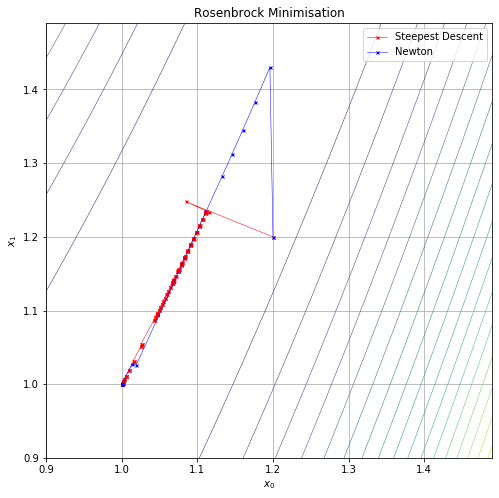

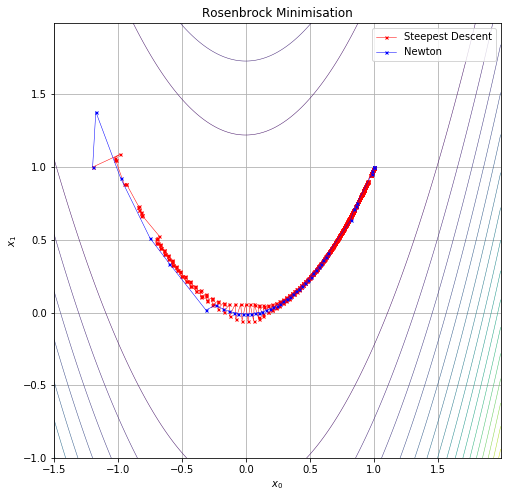

In [7]:
# Rosenbrock functionality test of Backtracking, Steepest Descent, and Newton

a = 1
b = 100

f   = lambda x: (a - x[0])**2 + b*(x[1] - x[0]**2)**2

df  = lambda x: np.array([-2.0 * (a - x[0]) - 4.0 * b * x[0] * (x[1] - x[0]**2),
                         2.0 * b * (x[1] - x[0]**2)])

d2f = lambda x: np.array([[2 + 8 * b * x[0]**2 - 4.0 * b * (x[1] - x[0]**2), -4.0 * b * x[0]],
                          [-4.0 * b * x[0], 2.0 * b]])

# rosenbrock_0.pdf

x0 = np.array([1.2, 1.2])

iters_steepest, xs_steepest = steepest_descent(f, df, d2f, x0)  # d2f ignored!
 
iters_newton, xs_newton = newton(f, df, d2f, x0)

x = np.arange(0.9, 1.5, 0.01)
y = np.arange(0.9, 1.5, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)
plt.plot(xs_steepest[:, 0], xs_steepest[:, 1], '-rx', linewidth=0.5, markersize=3)
plt.plot(xs_newton[:, 0], xs_newton[:, 1], '-bx', linewidth=0.5, markersize=3)

#s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
#s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
#s3 = "Iterations: {}".format(iters)
#box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(0.95, 1.42, s1 + s2 + s3, bbox=box_prop)

plt.title("Rosenbrock Minimisation")
plt.legend(["Steepest Descent", "Newton"])
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_0.pdf")
plt.show()


# rosenbrock_1.pdf

x0 = np.array([-1.2, 1.0])

iters_steepest, xs_steepest = steepest_descent(f, df, None, x0)  # d2f ignored.

iters_newton, xs_newton = newton(f, df, d2f, x0)

x = np.arange(-1.5, 2.0, 0.01)
y = np.arange(-1.0, 2.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = (a - xx)**2 + b * (yy - xx**2)**2

plt.figure(figsize=(8, 8))
plt.contour(x,y,z, linewidths=0.5, levels=20)
plt.plot(xs_steepest[:, 0], xs_steepest[:, 1], '-rx', linewidth=0.5, markersize=3)
plt.plot(xs_newton[:, 0], xs_newton[:, 1], '-bx', linewidth=0.5, markersize=3)

#s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
#s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
#s3 = "Iterations: {}".format(iters)
#box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(-1.25, 1.6, s1 + s2 + s3, bbox=box_prop)

plt.title("Rosenbrock Minimisation")
plt.legend(["Steepest Descent", "Newton"])
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.grid()
plt.savefig("rosenbrock_1.pdf")
plt.show()


# Linear Binary Classification SVM

## Implementation

The following code implements an SVM for linear binary classification. Note how the *linear_kernel* is written as *lambda* expression and passed to the *dual_solver_...()* functions as a parameter. This will make it easy to pass different kernels to the same solver. And also note now the *dual_solver_...()* functions are passed to the *svm()* function as a parameter. Again, this makes it easy to pass different *dual_solver* functionality to the SVM.

In [8]:
# Linear kernel function.

linear_kernel = lambda xi, xj: xi @ xj

In [9]:
# Linear SVM implementation.

def quadratic_penalty_dual_solver(X, y, kernel, descent_function, mu=500):

    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    f   = lambda x: 0.5 * x @ H @ x - x @ (x / x) + 0.5 * mu * (y @ x)**2
    df  = lambda x: H @ x - x / x + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y 

    iters, xs = descent_function(f, df, d2f, x0=np.ones(len(X)))

    return (iters, xs)


def augmented_lagrangian_dual_solver(X, y, kernel, descent_function, mu=500.0, gamma=0.0):

    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])
            
    f   = lambda x: 0.5 * x @ H @ x - x @ (x / x) + 0.5 * mu * (y @ x)**2 - gamma * (x @ (x / x))
    df  = lambda x: H @ x - x / x + mu * y * (y @ x) - gamma * (x / x)
    d2f = lambda x: H + mu * y * y 

    iters, xs = descent_function(f, df, d2f, x0=np.ones(len(X)))

    return (iters, xs)


import scipy

def scipy_cg_dual_solver(X, y, kernel, descent_function, mu=200):

    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    f   = lambda x: 0.5 * x @ H @ x - x @ (x / x) + 0.5 * mu * (y @ x)**2
    df  = lambda x: H @ x - x / x + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y 

    result = scipy.optimize.minimize(f, np.full((len(X)), 200), method='CG')
    
    return (result.nit, np.array([result.x]))


def kkt_system_dual_solver(X, y, kernel, descent_function=None):

    L = len(X)
    
    P = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            P[i, j] = y[i] * y[j] * kernel(X[i], X[j])
            
    q = np.full((L), -1.0)
    A = y
    KKT = np.zeros((L + 1, L + 1))
    KKT[0:L, 0:L] = P
    KKT[-1, 0:L] = A
    KKT[0:L, -1] = A
    RHS = np.zeros((L + 1))
    RHS[0:L] = -1.0 * q

    return (None, np.array([np.linalg.solve(KKT, RHS)[0:L]]))


def w_func(X, y, a):

    X_sv = X[np.nonzero(a > 0.0)]
    y_sv = y[np.nonzero(a > 0.0)]
    a_sv = a[np.nonzero(a > 0.0)]

    M, N = X_sv.shape
    w = np.zeros((N))
    for i in range(M):
        w = w + a_sv[i] * y_sv[i] * X_sv[i]

    return w


def b_func(X, y, a):

    X_sv = X[np.nonzero(a > 0.0)]
    y_sv = y[np.nonzero(a > 0.0)]
    a_sv = a[np.nonzero(a > 0.0)]

    b = 0.0
    for i in range(len(X_sv)):
        inner = 0.0
        for j in range(len(X_sv)):
            inner += a_sv[j] * y_sv[j] * (X_sv[i] @ X_sv[j])
        b += y_sv[i] - inner

    return b / len(X_sv)


class LinearSVM(object):
    
    def __init__(self):

        return
    

    def train(self, X, y, kernel, dual_solver, descent_method):

        assert len(X) == len(y), "X and y lengths mismatch"
        
        self.i, self.xs = dual_solver(X, y, kernel, descent_method)
        self.a          = self.xs[-1]
        self.s          = X[np.nonzero(self.a > 0.0)]
        self.w          = w_func(X, y, self.a)        
        self.b          = b_func(X, y, self.a)
        self.d          = 1.0 / np.linalg.norm(self.w)

        return


    def predict(self, x):

        return np.sign(self.w @ x + self.b)


## Linear SVM Test 1

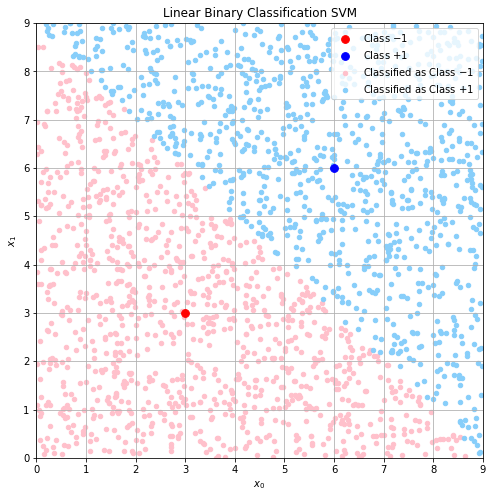

Itertions:
 115
Alphas:
 [0.12311629 0.11711603]
Support Vectors:
 [[3. 3.]
 [6. 6.]]
w:
 [0.33334727 0.33334727]
b:
 -3.0001254473834473
Margin:
 2.121231642573227




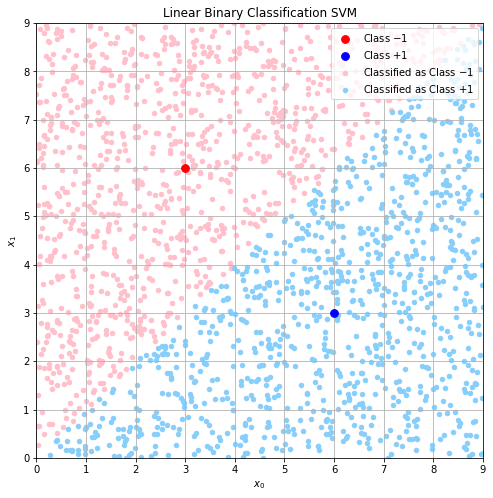

Itertions:
 8
Alphas:
 [0.11111112 0.11111112]
Support Vectors:
 [[3. 6.]
 [6. 3.]]
w:
 [ 0.33333336 -0.33333336]
b:
 0.0
Margin:
 2.121320173854028




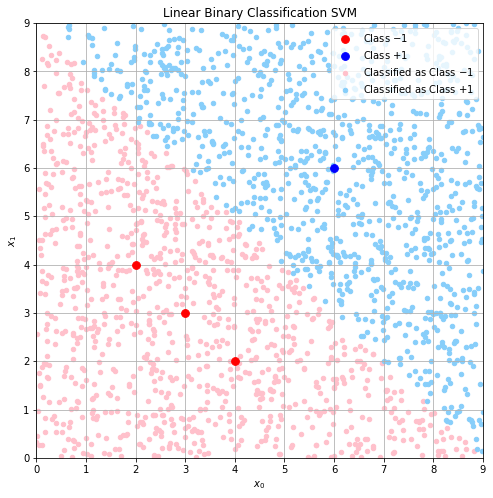

Itertions:
 1253
Alphas:
 [0.04104399 0.04104399 0.04104399 0.11713205]
Support Vectors:
 [[2. 4.]
 [3. 3.]
 [4. 2.]
 [6. 6.]]
w:
 [0.3333964 0.3333964]
b:
 -3.000473004866972
Margin:
 2.1209190615442166




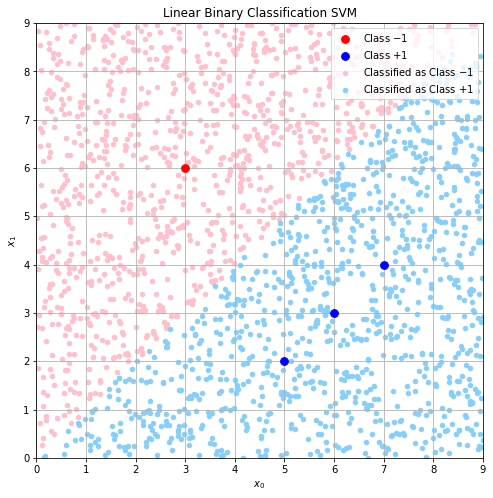

Itertions:
 1522
Alphas:
 [0.11111534 0.03697217 0.037038   0.03710384]
Support Vectors:
 [[3. 6.]
 [5. 2.]
 [6. 3.]
 [7. 4.]]
w:
 [ 0.33346966 -0.33321838]
b:
 -0.0011467909155819522
Margin:
 2.1212521606593167




In [10]:
# Linear SVM Test 1.

N = 2000

for plot, (X, y) in enumerate([([[3.0, 3.0], [6.0, 6.0]], [-1.0, +1.0]),
                               ([[3.0, 6.0], [6.0, 3.0]], [-1.0, +1.0]),
                               ([[2.0, 4.0], [3.0, 3.0], [4.0, 2.0], [6.0, 6.0]], [-1.0, -1.0, -1.0, +1.0]),
                               ([[3.0, 6.0], [5.0, 2.0], [6.0, 3.0], [7.0, 4.0]], [-1.0, +1.0, +1.0, +1.0])]):

    linear_svm = LinearSVM()

    X_train = np.array(X)
    y_train = np.array(y)

    linear_svm.train(X_train, y_train, linear_kernel, quadratic_penalty_dual_solver, steepest_descent)

    X_new = np.zeros((N, 2))

    for i in range(N):
        X_new[i, 0] = np.random.uniform(0.0, 9.0)
        X_new[i, 1] = np.random.uniform(0.0, 9.0)

    y_new = np.zeros(N)

    for i in range(N):
        y_new[i] = linear_svm.predict(X_new[i])

    plt.figure(figsize=(8, 8))
    plt.xlim((0.0, 9.0))
    plt.ylim((0.0, 9.0))
    plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
    plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
    plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
    plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
    plt.title("Linear Binary Classification SVM")
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
    plt.grid(zorder=0)
    plt.savefig("linear_svm_qp_{}.pdf".format(plot))
    plt.show()
    

    print("Itertions:\n", linear_svm.i)
    print("Alphas:\n", linear_svm.a)
    print("Support Vectors:\n", linear_svm.s)
    print("w:\n", linear_svm.w)
    print("b:\n", linear_svm.b)
    print("Margin:\n", linear_svm.d)
    print("\n")


## Linear SVM Test 2

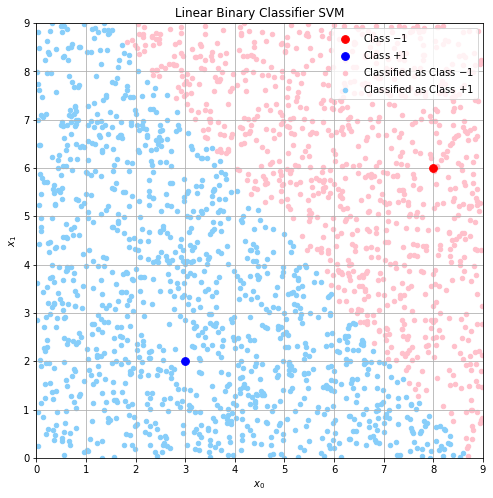

Itertions:
 130
Alphas:
 [0.0511614  0.05540453]
Support Vectors:
 [[8. 6.]
 [3. 2.]]
w:
 [-0.24307761 -0.19615934]
b:
 2.1215641830695042
Margin:
 3.2014926726185893




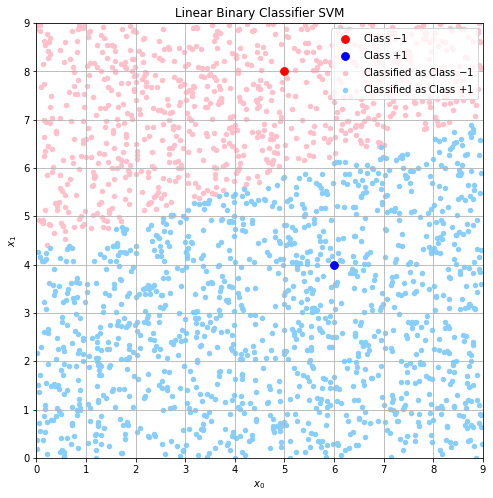

Itertions:
 73
Alphas:
 [0.12398024 0.11999477]
Support Vectors:
 [[6. 4.]
 [5. 8.]]
w:
 [ 0.14390759 -0.46403719]
b:
 1.9927313817034333
Margin:
 2.05829340488686




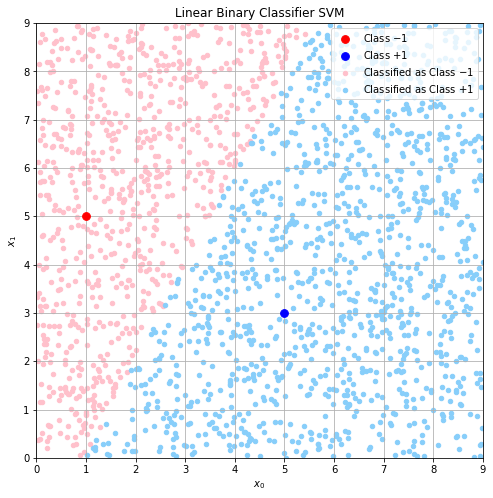

Itertions:
 15
Alphas:
 [0.09977248 0.10053556]
Support Vectors:
 [[5. 3.]
 [1. 5.]]
w:
 [ 0.39832682 -0.20336038]
b:
 -0.3815389411541442
Margin:
 2.2359578727262672




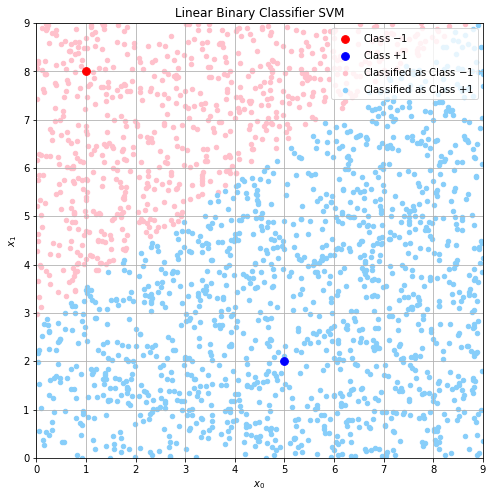

Itertions:
 89
Alphas:
 [0.0382602  0.03957198]
Support Vectors:
 [[1. 8.]
 [5. 2.]]
w:
 [ 0.15959972 -0.22693763]
b:
 0.6558890254531922
Margin:
 3.604387490255304




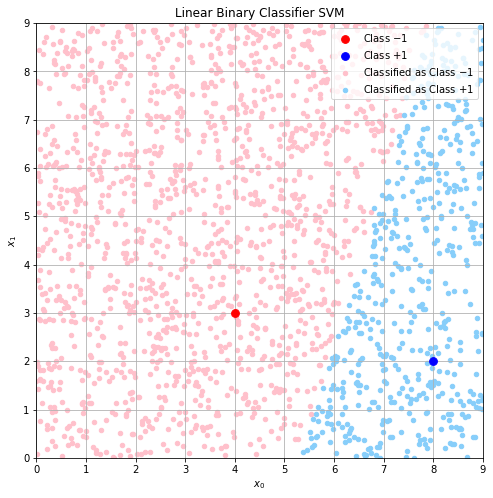

Itertions:
 139
Alphas:
 [0.12140577 0.12631684]
Support Vectors:
 [[8. 2.]
 [4. 3.]]
w:
 [ 0.46597879 -0.13613897]
b:
 -2.455525313205409
Margin:
 2.0599078807794475




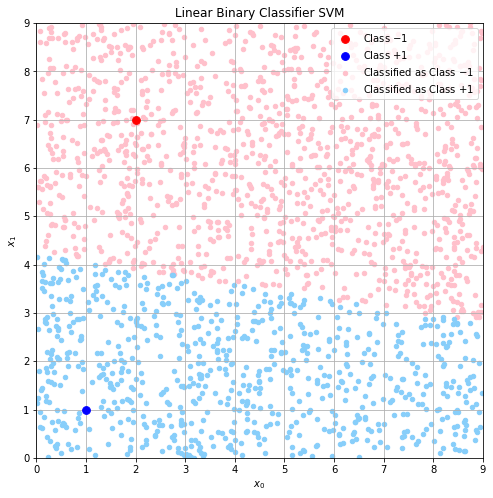

Itertions:
 113
Alphas:
 [0.05457255 0.05732547]
Support Vectors:
 [[2. 7.]
 [1. 1.]]
w:
 [-0.05181963 -0.32468239]
b:
 1.3764589928748554
Margin:
 3.0414400924719174




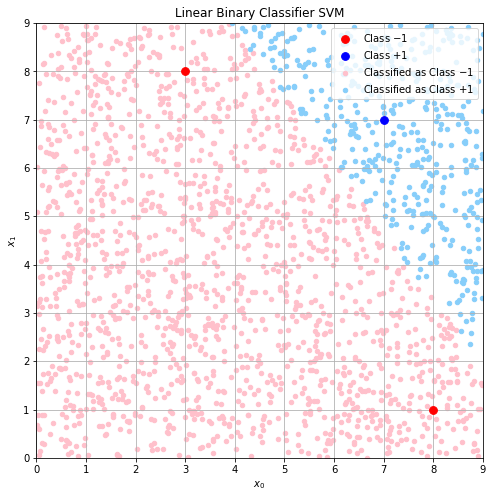

Itertions:
 1142
Alphas:
 [0.12129171 0.20460131 0.31328162]
Support Vectors:
 [[8. 1.]
 [3. 8.]
 [7. 7.]]
w:
 [0.60883374 0.43486914]
b:
 -6.305637872919024
Margin:
 1.3365572007507145




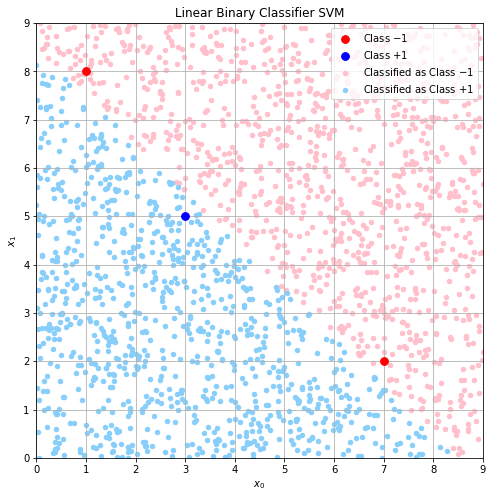

Itertions:
 7505
Alphas:
 [4.2930812  1.76901992 2.49016403]
Support Vectors:
 [[3. 5.]
 [7. 2.]
 [1. 8.]]
w:
 [-1.99405988 -1.9939461 ]
b:
 16.94795007465403
Margin:
 0.3546167100540451




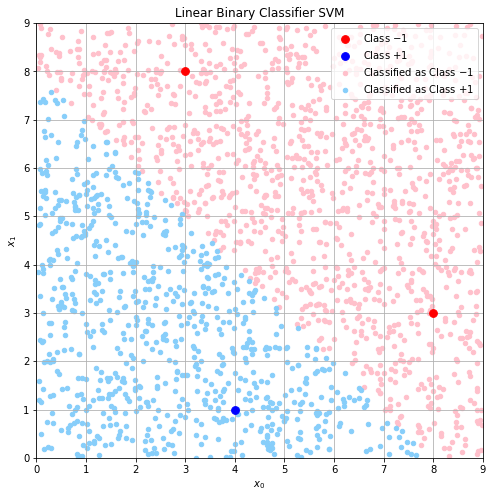

Itertions:
 537
Alphas:
 [0.09405315 0.12089808 0.02151107]
Support Vectors:
 [[8. 3.]
 [4. 1.]
 [3. 8.]]
w:
 [-0.33336614 -0.33334998]
b:
 2.6668973049341815
Margin:
 2.121162983736238




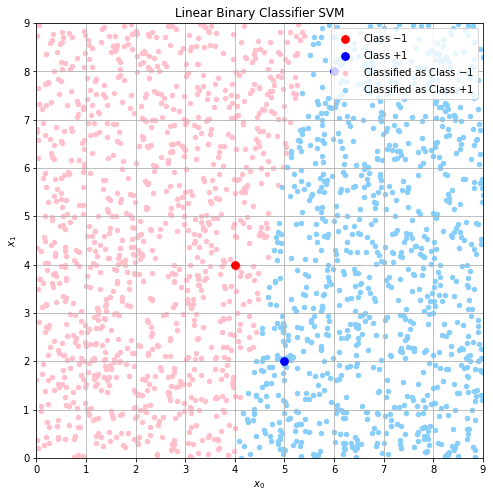

Itertions:
 1781
Alphas:
 [1.19927107 0.82521466 0.36204603]
Support Vectors:
 [[4. 4.]
 [5. 2.]
 [6. 8.]]
w:
 [ 1.50126521 -0.25028672]
b:
 -6.004988009483206
Margin:
 0.6570363700346306




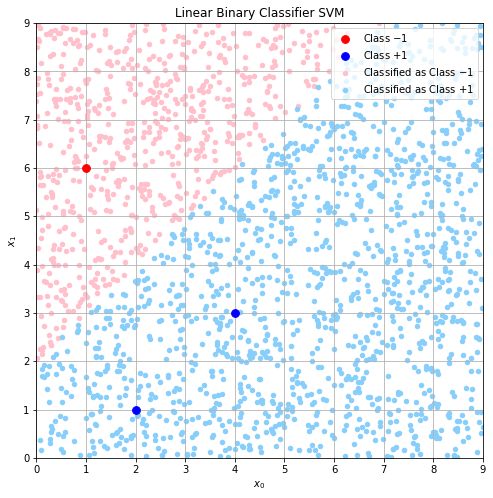

Itertions:
 986
Alphas:
 [0.10991859 0.00231016 0.11089585]
Support Vectors:
 [[4. 3.]
 [2. 1.]
 [1. 6.]]
w:
 [ 0.33339884 -0.33330914]
b:
 0.6664331777472177
Margin:
 2.121188851672618




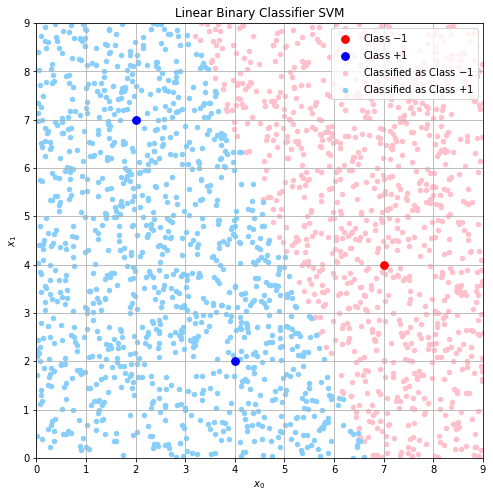

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]
w:
 [-0.52637123 -0.21058176]
b:
 3.526796306329785
Margin:
 1.7638814512223358




In [11]:
# Linear SVM Test 2.

np.random.seed(5)

N = 2000

for T in [2, 3]:

    for plot in range(6):

        linear_svm = LinearSVM()

        X_train = np.zeros((T, 2))
        y_train = np.zeros(T)

        X_train[:, 0] = np.random.choice(range(1, 9), size=(T), replace=False)
        X_train[:, 1] = np.random.choice(range(1, 9), size=(T), replace=False)

        y_train[:] = np.random.choice([-1.0, +1.0], size=(T))
        if len(y_train[y_train == -1.0]) == 0:
            y_train[np.random.randint(0, T)] = -1.0    
        if len(y_train[y_train == +1.0]) == 0:
            y_train[np.random.randint(0, T)] = +1.0    

        linear_svm.train(X_train, y_train, linear_kernel, quadratic_penalty_dual_solver, steepest_descent)

        X_new = np.zeros((N, 2))

        for i in range(N):
            X_new[i, 0] = np.random.uniform(0.0, 9.0)
            X_new[i, 1] = np.random.uniform(0.0, 9.0)

        y_new = np.zeros(N)

        for i in range(N):
            y_new[i] = linear_svm.predict(X_new[i])

        plt.figure(figsize=(8, 8))
        plt.xlim((0.0, 9.0))
        plt.ylim((0.0, 9.0))
        plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
        plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
        plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
        plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
        #for sv in svm.sv:
        #    plt.scatter(sv[0], sv[1], s=300, facecolors='none', edgecolors='b')
        plt.title("Linear Binary Classifier SVM")
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
        plt.grid(zorder=0)
        plt.savefig("linear_svm_rand_qp_{}_{}.pdf".format(T, plot))
        plt.show()

        print("Itertions:\n", linear_svm.i)
        print("Alphas:\n", linear_svm.a)
        print("Support Vectors:\n", linear_svm.s)
        print("w:\n", linear_svm.w)
        print("b:\n", linear_svm.b)
        print("Margin:\n", linear_svm.d)
        print("\n")


# Linear Optimisation Problem

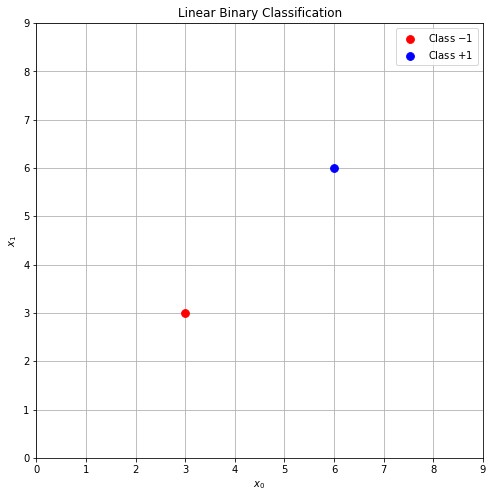

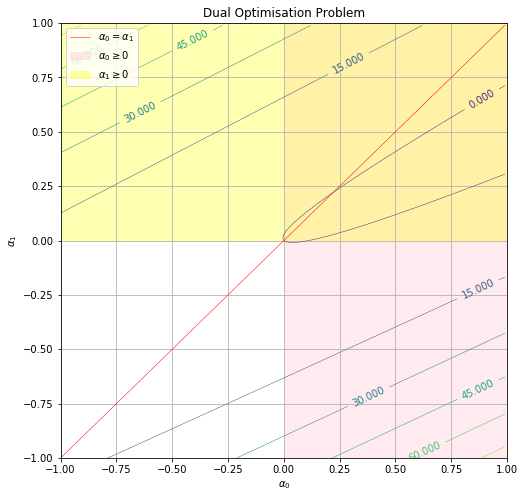

In [25]:
# Linear Optimisation Problem.

X = np.array([[3.0, 3.0], [6.0, 6.0]])
y = np.array([-1.0, +1.0])

plt.figure(figsize=(8, 8))
plt.xlim((0.0, 9.0))
plt.ylim((0.0, 9.0))
plt.scatter(X[y == -1.0, 0], X[y == -1.0, 1], color="red", s=60, zorder=2)
plt.scatter(X[y == +1.0, 0], X[y == +1.0, 1], color="blue", s=60, zorder=2)
plt.title("Linear Binary Classification")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(["Class $-1$", "Class $+1$"], loc="upper right")
plt.grid(zorder=0)
plt.savefig("linear_problem_data_0.pdf")
plt.show()

L = len(X)
H = np.zeros((L, L))
for i in range(L):
    for j in range(L):
        H[i, j] = y[i] * y[j] * linear_kernel(X[i], X[j])

f   = lambda x: 0.5 * x.T @ H @ x - x.T @ (x / x)
df  = lambda x: H @ x - x / x
d2f = lambda x: H

g = lambda x, y: f(np.array([x, y]))
z = np.vectorize(g)

x_range = np.arange(-1.0, 1.0, 0.01)
y_range = np.arange(-1.0, 1.0, 0.01)

x, y = np.meshgrid(x_range, y_range)

plt.figure(figsize=(8, 8))
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))
plt.title("Dual Optimisation Problem")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")
cs = plt.contour(x, y, z(x, y), linewidths=0.5)
plt.clabel(cs)
plt.fill(np.array([0.0, 0.0, 14.0, 14.0]), np.array([-2.0, 14.0, 14.0, -2.0]), alpha=0.3, color="pink", label=r"$\alpha_0 \geq 0$")
plt.fill(np.array([-2.0, -2.0, 14.0, 14.0]), np.array([0.0, 14.0, 14.0, 0.0]), alpha=0.3, color="yellow", label=r"$\alpha_1 \geq 0$")
plt.plot(x_range, y_range, '-r', linewidth=0.5, label=r"$\alpha_0 = \alpha_1$")
plt.grid()
plt.legend()
plt.savefig("linear_problem_dual_0.pdf")
plt.show()

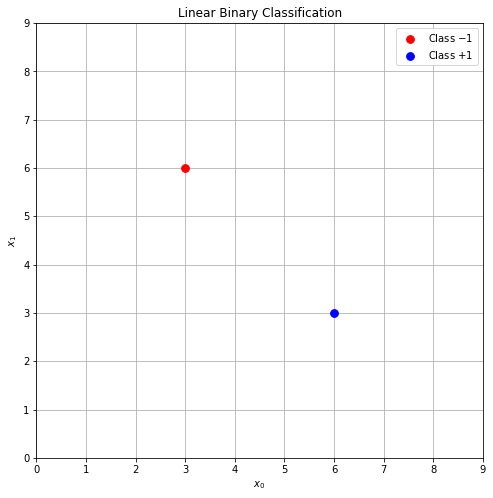

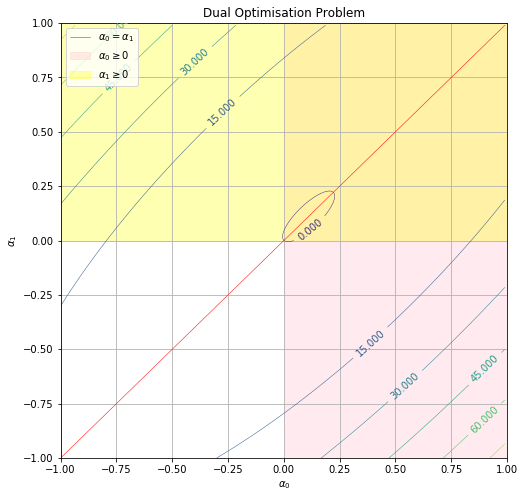

In [26]:
# Linear Optimisation Problem.

X = np.array([[3.0, 6.0], [6.0, 3.0]])
y = np.array([-1.0, +1.0])

plt.figure(figsize=(8, 8))
plt.xlim((0.0, 9.0))
plt.ylim((0.0, 9.0))
plt.scatter(X[y == -1.0, 0], X[y == -1.0, 1], color="red", s=60, zorder=2)
plt.scatter(X[y == +1.0, 0], X[y == +1.0, 1], color="blue", s=60, zorder=2)
plt.title("Linear Binary Classification")
plt.xlabel("$x_0$")
plt.ylabel("$x_1$")
plt.legend(["Class $-1$", "Class $+1$"], loc="upper right")
plt.grid(zorder=0)
plt.savefig("linear_problem_data_1.pdf")
plt.show()

L = len(X)
H = np.zeros((L, L))
for i in range(L):
    for j in range(L):
        H[i, j] = y[i] * y[j] * linear_kernel(X[i], X[j])

f   = lambda x: 0.5 * x.T @ H @ x - x.T @ (x / x)
df  = lambda x: H @ x - x / x
d2f = lambda x: H

g = lambda x, y: f(np.array([x, y]))
z = np.vectorize(g)

x_range = np.arange(-1.0, 1.0, 0.01)
y_range = np.arange(-1.0, 1.0, 0.01)

x, y = np.meshgrid(x_range, y_range)

plt.figure(figsize=(8, 8))
plt.xlim((-1.0, 1.0))
plt.ylim((-1.0, 1.0))
plt.title("Dual Optimisation Problem")
plt.xlabel(r"$\alpha_0$")
plt.ylabel(r"$\alpha_1$")
cs = plt.contour(x, y, z(x, y), linewidths=0.5)
plt.clabel(cs)
plt.fill(np.array([0.0, 0.0, 14.0, 14.0]), np.array([-2.0, 14.0, 14.0, -2.0]), alpha=0.3, color="pink", label=r"$\alpha_0 \geq 0$")
plt.fill(np.array([-2.0, -2.0, 14.0, 14.0]), np.array([0.0, 14.0, 14.0, 0.0]), alpha=0.3, color="yellow", label=r"$\alpha_1 \geq 0$")
plt.plot(x_range, y_range, '-r', linewidth=0.5, label=r"$\alpha_0 = \alpha_1$")
plt.grid()
plt.legend()
plt.savefig("linear_problem_dual_1.pdf")
plt.show()

# Solving Linear Optimisation Problem

In [14]:
# Algorithm 1 - ???

In [15]:
# Algorithm 2 - ???

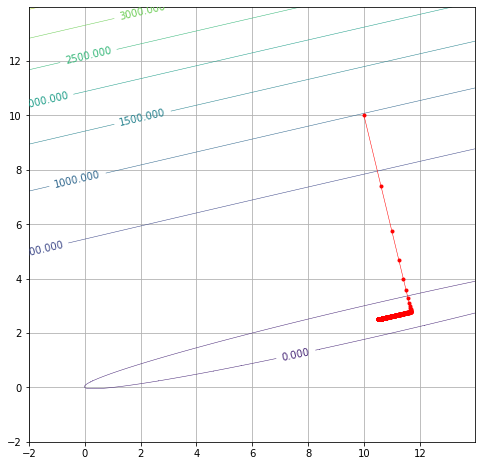

In [16]:
f = lambda x : x[0]**2 + 17 * x[1]**2 - 8.0 * x[0] * x[1] - x[0] - x[1]

df = lambda x : np.array([2.0 * x[0] - 8.0 * x[1] - 1.0,
                          34.0 * x[1] - 8.0 * x[0] - 1.0])

#f = lambda x: 0.5 * x @ H @ x - np.sum(x)
    
#df = lambda x: (np.transpose(H) + H) @ x - np.ones(len(x))
                 
x0 = np.array([10.0, 10.0])

iters, xs = steepest_descent(f, df, None, x0)

x = np.arange(-2.0, 14.0, 0.01)
y = np.arange(-2.0, 14.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = xx**2 + 17.0 * yy**2 - 8.0 * xx * yy - xx - yy

plt.figure(figsize=(8, 8))
cs = plt.contour(x,y,z, linewidths=0.5)
plt.clabel(cs)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
#s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
#s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
#s3 = "Iterations: {}".format(iters)
#box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(-1.6, 12.4, s1 + s2 + s3, bbox=box_prop)
plt.grid()
plt.savefig("motiv_0.pdf")
plt.show()

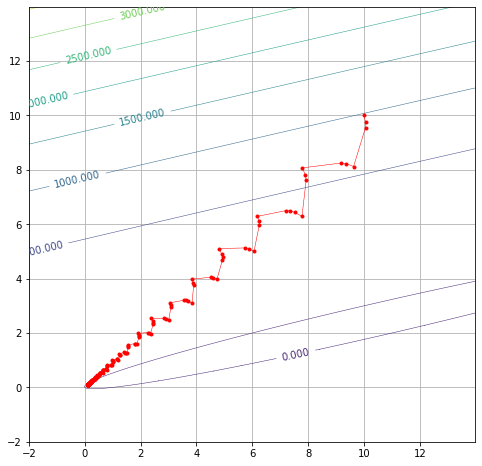

In [17]:
# Quadratic Penalty Method for solving the Dual Problem.

mu = 200

f = lambda x : x[0]**2 + 17 * x[1]**2 - 8.0 * x[0] * x[1] - x[0] - x[1] + mu / 2.0 * (-1.0 * x[0] + 1.0 *x[1])**2

df = lambda x : np.array([2.0 * x[0] - 8.0 * x[1] - 1.0 - mu * (-1.0 * x[0] + 1.0 * x[1]),
                          34.0 * x[1] - 8.0 * x[0] - 1.0 + mu * (-1.0 * x[0] + 1.0 * x[1])])



x0 = np.array([10.0, 10.0])

iters, xs = steepest_descent(f, df, None, x0)

alphas = xs[-1]

x = np.arange(-2.0, 14.0, 0.01)
y = np.arange(-2.0, 14.0, 0.01)
xx, yy = np.meshgrid(x, y)
z = xx**2 + 17.0 * yy**2 - 8.0 * xx * yy - xx - yy

plt.figure(figsize=(8, 8))
cs = plt.contour(x,y,z, linewidths=0.5)
plt.clabel(cs)
plt.plot(xs[:, 0], xs[:, 1], '-ro', linewidth=0.5, markersize=3)
#s1 = "Start:        [{:.1f}, {:.1f}]\n".format(x0[0], x0[1])
#s2 = "Minimum: [{:.6f}, {:.6f}]\n".format(xs[-1][0], xs[-1][1])
#s3 = "Iterations: {}".format(iters)
#box_prop = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
#plt.text(-1.6, 12.4, s1 + s2 + s3, bbox=box_prop)
plt.grid()
plt.savefig("motiv_1.pdf")
plt.show()

# Non-Linear Binary Classification SVM

## Implementation

In [18]:
# Non-linear kernel function.

gaussian_kernel = lambda xi, xj: np.exp(-0.5 * np.linalg.norm(xi - xj)**2)  # Sigma = 1.0


In [19]:
# Non-Linear Binary Classification SVM implementation.

def quadratic_penatly_dual_solver(X, y, kernel, descent_function, mu=200.0):

    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    #f   = lambda x: 0.5 * x @ H @ x - np.sum(x) + 0.5 * mu * (y @ x)**2 
    #df  = lambda x: H @ x - np.ones(len(x)) + mu * y * (y @ x)
    #d2f = lambda x: H + mu * y * y

    f   = lambda x: 0.5 * x @ H @ x - x @ (x / x) + 0.5 * mu * (y @ x)**2 
    df  = lambda x: H @ x - x / x + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y

    i, xs = descent_function(f, df, d2f, x0=np.ones(len(X)))

    return (i, xs)


def augmented_lagrangian_dual_solver(X, y, kernel, descent_function, mu=200.0):

    L = len(X)
    
    H = np.zeros((L, L))
    for i in range(L):
        for j in range(L):
            H[i, j] = y[i] * y[j] * kernel(X[i], X[j])

    #f   = lambda x: 0.5 * x @ H @ x - np.sum(x) + 0.5 * mu * (y @ x)**2 
    #df  = lambda x: H @ x - np.ones(len(x)) + mu * y * (y @ x)
    #d2f = lambda x: H + mu * y * y

    f   = lambda x: 0.5 * x @ H @ x - x @ (x / x) + 0.5 * mu * (y @ x)**2 
    df  = lambda x: H @ x - x / x + mu * y * (y @ x)
    d2f = lambda x: H + mu * y * y

    i, xs = descent_function(f, df, d2f, x0=np.ones(len(X)))

    return (i, xs)


class NonLinearSVM(object):

    def __init__(self):        

        return


    def train(self, X, y, kernel, dual_solver, descent_method):

        assert len(X) == len(y), "X and y lengths mismatch"

        self.i, self.xs = dual_solver(X, y, kernel, descent_method)
        self.a          = self.xs[-1]
        self.s          = X[np.where(self.a > 0.0)]
        self.b          = 0.0
        
        return


    def predict(self, X, y, kernel, x):
        
        b = self.b
        for i in range(len(X)):
            b+= self.a[i] * y[i] * kernel(X[i], x)

        return np.sign(b)


## Non-Linear SVM Test 1

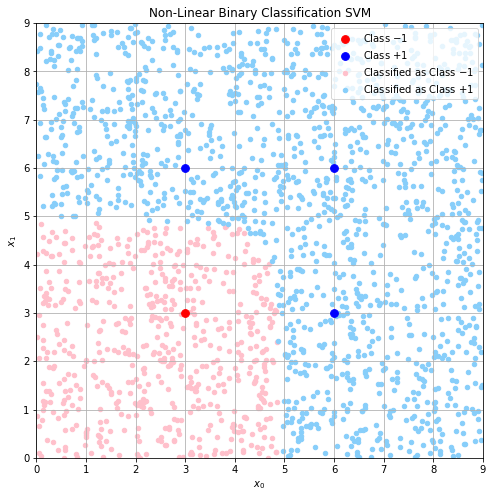

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




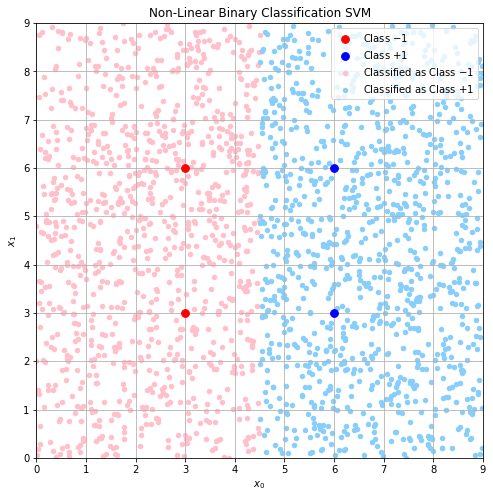

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




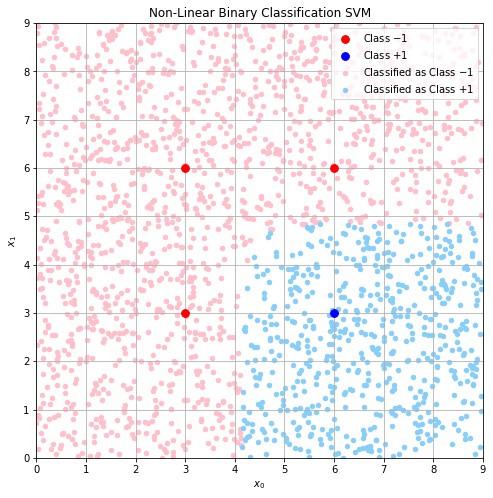

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




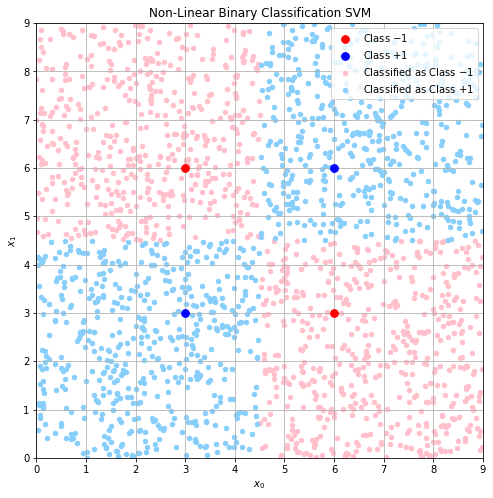

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




In [20]:
# Non-Linear SVM Test 1.

N = 2000

for plot, (X, y) in enumerate([([[3.0, 3.0], [3.0, 6.0], [6.0, 3.0], [6.0, 6.0]], [-1.0, +1.0, +1.0, +1.0]),
                               ([[3.0, 3.0], [3.0, 6.0], [6.0, 3.0], [6.0, 6.0]], [-1.0, -1.0, +1.0, +1.0]),
                               ([[3.0, 3.0], [3.0, 6.0], [6.0, 3.0], [6.0, 6.0]], [-1.0, -1.0, +1.0, -1.0]),
                               ([[3.0, 3.0], [3.0, 6.0], [6.0, 3.0], [6.0, 6.0]], [+1.0, -1.0, -1.0, +1.0])]):

    non_linear_svm = NonLinearSVM()

    X_train = np.array(X)
    y_train = np.array(y)

    non_linear_svm.train(X_train, y_train, gaussian_kernel, quadratic_penalty_dual_solver, steepest_descent)

    X_new = np.zeros((N, 2))

    for i in range(N):
        X_new[i, 0] = np.random.uniform(0.0, 9.0)
        X_new[i, 1] = np.random.uniform(0.0, 9.0)

    y_new = np.zeros(N)

    for i in range(N):
        y_new[i] = non_linear_svm.predict(X_train, y_train, gaussian_kernel, X_new[i])

    plt.figure(figsize=(8, 8))
    plt.xlim((0.0, 9.0))
    plt.ylim((0.0, 9.0))
    plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
    plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
    plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
    plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
    plt.title("Non-Linear Binary Classification SVM")
    plt.xlabel("$x_0$")
    plt.ylabel("$x_1$")
    plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
    plt.grid(zorder=0)
    plt.savefig("non_linear_svm_qp_{}.pdf".format(plot))
    plt.show()

    print("Itertions:\n", linear_svm.i)
    print("Alphas:\n", linear_svm.a)
    print("Support Vectors:\n", linear_svm.s)
    print("\n")


## Non-Linear SVM Test 2

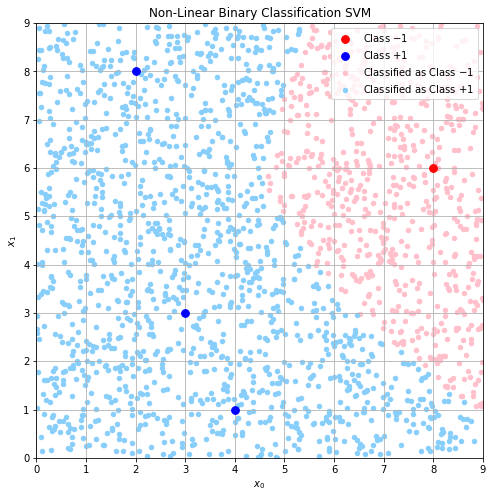

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




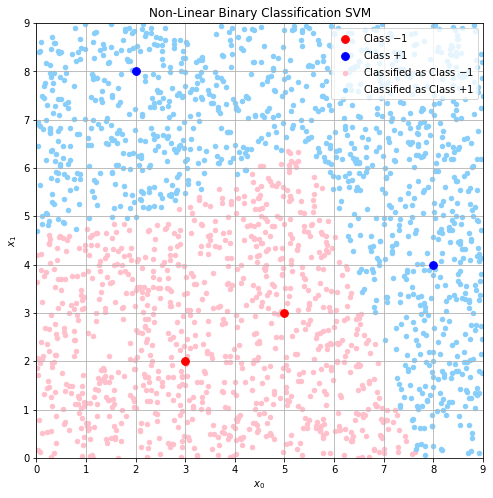

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




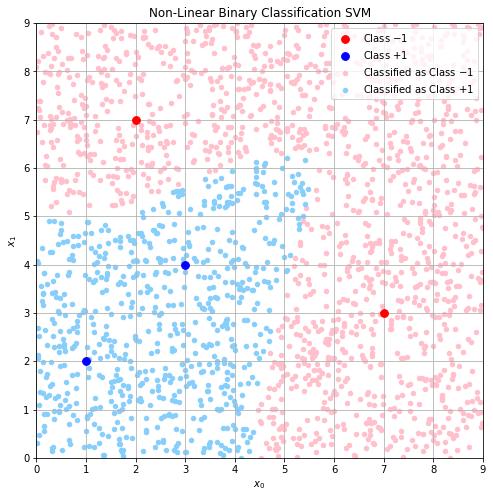

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




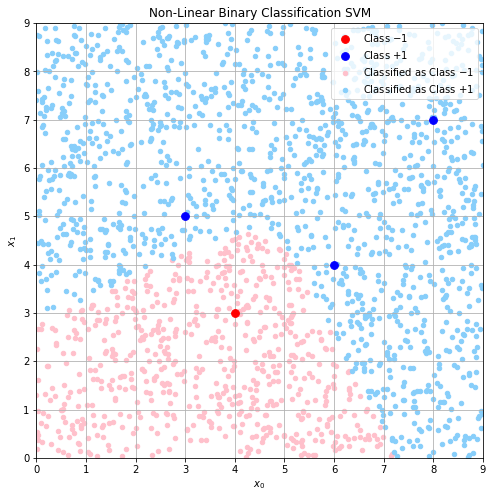

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




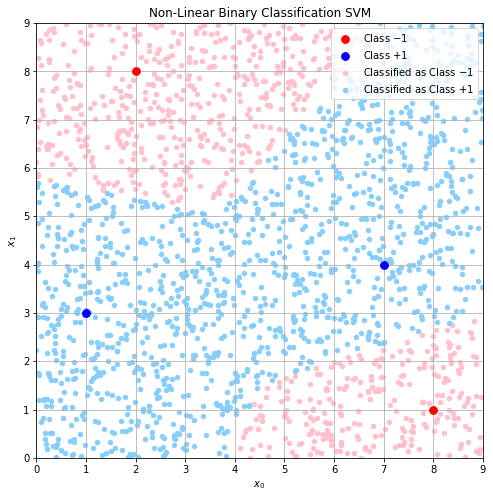

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




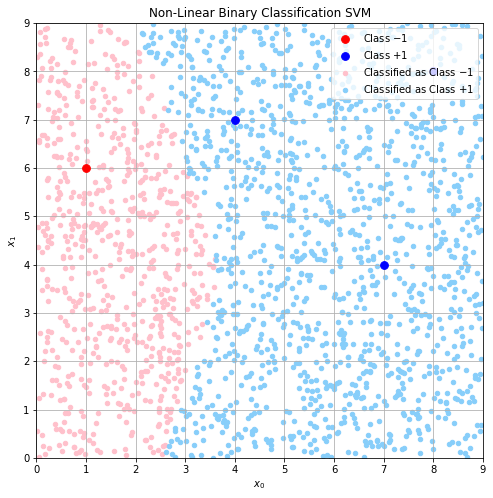

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




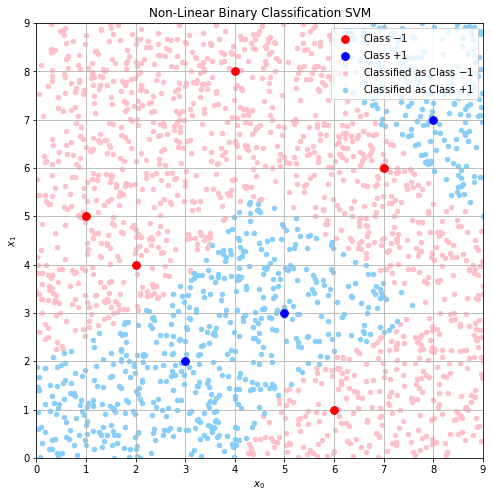

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




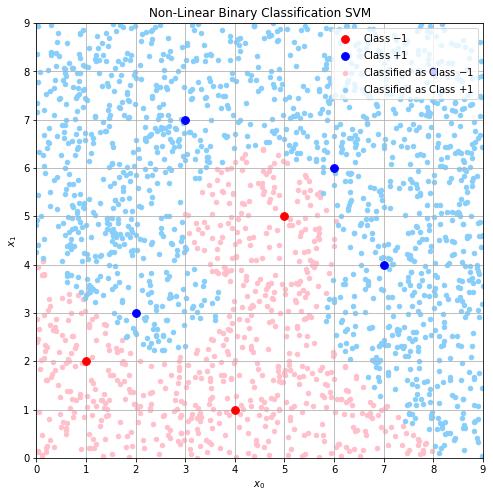

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




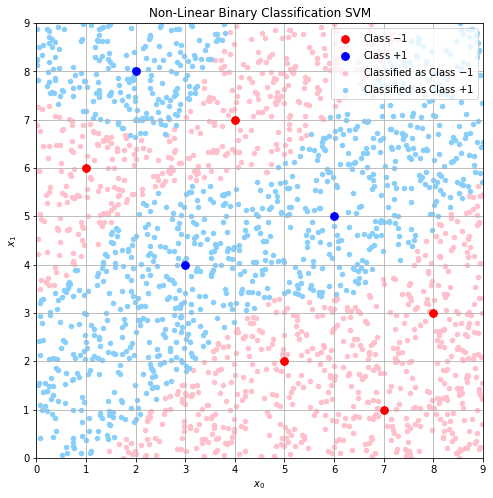

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




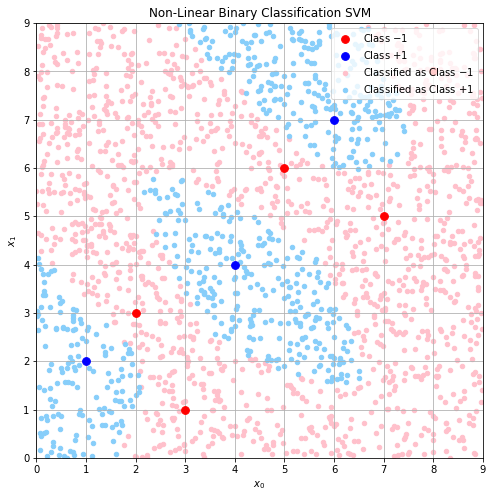

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




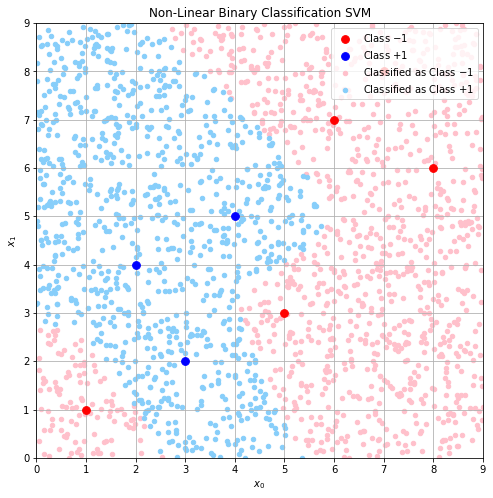

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




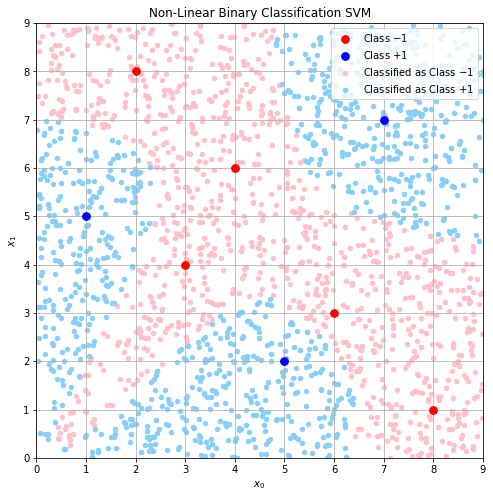

Itertions:
 748
Alphas:
 [0.02290024 0.15374857 0.16959514]
Support Vectors:
 [[2. 7.]
 [4. 2.]
 [7. 4.]]




In [21]:
# Non-Linear SVM Test 2

np.random.seed(9)

N = 2000

for T in [4, 8]:

    for plot in range(6):

        non_linear_svm = NonLinearSVM()

        X_train = np.zeros((T, 2))
        y_train = np.zeros(T)

        X_train[:, 0] = np.random.choice(range(1, 9), size=(T), replace=False)
        X_train[:, 1] = np.random.choice(range(1, 9), size=(T), replace=False)

        y_train[:] = np.random.choice([-1.0, +1.0], size=(T))
        if len(y_train[y_train == -1.0]) == 0:
            y_train[np.random.randint(0, T)] = -1.0    
        if len(y_train[y_train == +1.0]) == 0:
            y_train[np.random.randint(0, T)] = +1.0    

        non_linear_svm.train(X_train, y_train, gaussian_kernel, quadratic_penalty_dual_solver, steepest_descent)

        X_new = np.zeros((N, 2))

        for i in range(N):
            X_new[i, 0] = np.random.uniform(0.0, 9.0)
            X_new[i, 1] = np.random.uniform(0.0, 9.0)

        y_new = np.zeros(N)

        for i in range(N):
            y_new[i] = non_linear_svm.predict(X_train, y_train, gaussian_kernel, X_new[i])

        plt.figure(figsize=(8, 8))
        plt.xlim((0.0, 9.0))
        plt.ylim((0.0, 9.0))
        plt.scatter(X_train[y_train == -1.0, 0], X_train[y_train == -1.0, 1], color="red", s=60, zorder=2)
        plt.scatter(X_train[y_train == +1.0, 0], X_train[y_train == +1.0, 1], color="blue", s=60, zorder=2)
        plt.scatter(X_new[y_new == -1.0, 0], X_new[y_new == -1.0, 1], color="pink", s=20, zorder=1)
        plt.scatter(X_new[y_new == +1.0, 0], X_new[y_new == +1.0, 1], color="lightskyblue", s=20, zorder=1)
        plt.title("Non-Linear Binary Classification SVM")
        plt.xlabel("$x_0$")
        plt.ylabel("$x_1$")
        plt.legend([ "Class $-1$", "Class $+1$", "Classified as Class $-1$", "Classified as Class $+1$"], loc="upper right")
        plt.grid(zorder=0)
        plt.savefig("non_linear_svm_rand_qp_{}_{}.pdf".format(T, plot))
        plt.show()

        print("Itertions:\n", linear_svm.i)
        print("Alphas:\n", linear_svm.a)
        print("Support Vectors:\n", linear_svm.s)
        print("\n")
